# Assignment 2: ML Experiments with Feature Store and Pipeline
## MLflow + Feast
## Peter Ye

In [34]:
from datetime import datetime
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from feast import FeatureStore
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
import mlflow
from mlflow.tracking import MlflowClient
import seaborn as sns
from codecarbon import EmissionsTracker

In [125]:
import warnings
warnings.filterwarnings("ignore", message=r"\[.*WARNING.*\]", category=UserWarning)

## 0.0.0 Initialize the Feast repo called athletes repo to current directory

In [ ]:
!pwd

In [ ]:
!feast init -m athletes_repo

In [103]:
!ls

Assignment_2.ipynb  athletes.csv  athletes_repo


## 1.0.0 Pre-processing to create different feature views to simulate

In [5]:
# Load the original CSV
athletes_df = pd.read_csv('athletes.csv')

### 1.1.0 Data cleaning: drop null values, irrelevant columns. and remove outliers

In [7]:
# Dropping rows with null values
athletes_df = athletes_df.dropna(subset=['region','age','weight','height','howlong','gender','eat',
                               'train','background','experience','schedule','howlong',
                               'deadlift','candj','snatch','backsq','experience',
                               'background','schedule','howlong'])

In [8]:
# Dropping irrelevant columns
athletes_df = athletes_df.drop(columns=['affiliate','team','name','fran','helen','grace',
                              'filthy50','fgonebad','run400','run5k','pullups','train'])

In [9]:
# Remove outliers
athletes_df = athletes_df[athletes_df['weight'] < 1500]
athletes_df = athletes_df[athletes_df['gender'] != '--']
athletes_df = athletes_df[athletes_df['age'] >= 18]
athletes_df = athletes_df[(athletes_df['height'] < 96) & (athletes_df['height'] > 48)]
athletes_df = athletes_df[(athletes_df['deadlift'] > 0) & 
                ((athletes_df['deadlift'] <= 1105) | 
                ((athletes_df['gender'] == 'Female') & (athletes_df['deadlift'] <= 636)))]
athletes_df = athletes_df[(athletes_df['candj'] > 0) & (athletes_df['candj'] <= 395)]
athletes_df = athletes_df[(athletes_df['snatch'] > 0) & (athletes_df['snatch'] <= 496)]
athletes_df = athletes_df[(athletes_df['backsq'] > 0) & (athletes_df['backsq'] <= 1069)]

In [10]:
# Clean survey data
decline_dict = {'Decline to answer|': np.nan}
athletes_df = athletes_df.replace(decline_dict)
athletes_df = athletes_df.dropna(subset=['background','experience','schedule','howlong','eat'])

### 1.2.0 Create the target variable 'total_lift' column

In [11]:
# Create 'total_lift' column
athletes_df['total_lift'] = athletes_df['candj'] + athletes_df['snatch'] + athletes_df['deadlift'] + athletes_df['backsq']

### 1.3.0 Create 'event_timestamp' column which Feast requires an event_timestamp column even when performing offline feature retrieval

In [12]:
# Add an event_timestamp column with today's timestamp
athletes_df['event_timestamp'] = pd.Timestamp.now()

### 1.4.0 Split the data into athletes_predictors_df and athletes_target_df

In [13]:
# Split the data
athletes_target_df = athletes_df[['athlete_id', 'event_timestamp', 'total_lift', 'candj', 'snatch', 'deadlift', 'backsq']]
athletes_predictors_df = athletes_df.drop(columns=['total_lift', 'candj', 'snatch', 'deadlift', 'backsq'])

### 1.5.0 Create the first version of features

In [14]:
athletes_predictors_df_v1 = athletes_predictors_df.copy()

In [15]:
# Convert gender to binary number
athletes_predictors_df_v1['gender'] = athletes_predictors_df_v1['gender'].map({'Male': 1, 'Female': 0})

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Select columns to normalize
athletes_predictors_df_v1[['age', 'height', 'weight']] = scaler.fit_transform(athletes_predictors_df_v1[['age', 'height', 'weight']])

### 1.6.0 Create another version of features

In [17]:
athletes_predictors_df_v2 = athletes_predictors_df_v1.copy()

In [18]:
# Adding new columns based on the specified conditions
athletes_predictors_df_v2['experience_start_with_coach'] = athletes_predictors_df_v2['experience'].apply(
    lambda x: 1 if 'I began CrossFit with a coach' in x else 0
)

athletes_predictors_df_v2['experience_have_certificate'] = athletes_predictors_df_v2['experience'].apply(
    lambda x: 1 if 'I have completed the CrossFit Level 1 certificate course' in x else 0
)

athletes_predictors_df_v2['eat_on_diet'] = athletes_predictors_df_v2['eat'].apply(
    lambda x: 1 if 'I eat strict Paleo' in x else 0
)

### 1.7.0 Subset each features and save them with Parquet format into data directory 

In [19]:
# Subset features
athletes_predictors_df_v1 = athletes_predictors_df_v1[['athlete_id', 'event_timestamp', 'age', 'height', 'weight', 'gender']]

athletes_predictors_df_v2 = athletes_predictors_df_v2[['athlete_id', 'event_timestamp', 'age', 'height', 'weight', 'gender', 'experience_start_with_coach', 'experience_have_certificate', 'eat_on_diet']]

In [20]:
athletes_predictors_df_v1.head()

,athlete_id,event_timestamp,age,height,weight,gender
21,21269.0,2024-10-30 16:18:13.895796,0.315789,0.612903,0.415778,1
22,21685.0,2024-10-30 16:18:13.895796,0.263158,0.580645,0.364606,1
27,25464.0,2024-10-30 16:18:13.895796,0.447368,0.516129,0.469083,1
50,43767.0,2024-10-30 16:18:13.895796,0.473684,0.612903,0.413646,1
60,55504.0,2024-10-30 16:18:13.895796,0.473684,0.387097,0.319829,1


In [21]:
athletes_predictors_df_v2.head()

,athlete_id,event_timestamp,age,height,weight,gender,experience_start_with_coach,experience_have_certificate,eat_on_diet
21,21269.0,2024-10-30 16:18:13.895796,0.315789,0.612903,0.415778,1,0,0,0
22,21685.0,2024-10-30 16:18:13.895796,0.263158,0.580645,0.364606,1,1,0,0
27,25464.0,2024-10-30 16:18:13.895796,0.447368,0.516129,0.469083,1,1,0,0
50,43767.0,2024-10-30 16:18:13.895796,0.473684,0.612903,0.413646,1,1,1,0
60,55504.0,2024-10-30 16:18:13.895796,0.473684,0.387097,0.319829,1,0,1,1


In [22]:
# Define the path for the data directory
data_path = "athletes_repo/feature_repo/data"

# Create the directory
os.makedirs(data_path, exist_ok=True)

In [23]:
# Save to Parquet format
athletes_predictors_df_v1.to_parquet(path=data_path + '/athletes_predictors_df_v1.parquet')
athletes_predictors_df_v2.to_parquet(path=data_path + '/athletes_predictors_df_v2.parquet')
athletes_target_df.to_parquet(path=data_path + '/athletes_target_df.parquet')

## 2.0.0 Define feature stores and schema for athletes_repo

### 2.1.0 Update feature_store.yaml

In [24]:
# Update feature_store.yaml
feature_store_yaml_content = """
project: athletes_project
registry: data/registry.db
provider: local
online_store:
    type: sqlite
    path: data/online_store.db
offline_store:
    type: file
entity_key_serialization_version: 2
"""

# Write the content to feature_store.yaml
with open('athletes_repo/feature_repo/feature_store.yaml', 'w') as f:
    f.write(feature_store_yaml_content.strip())

print("Updated feature_store.yaml")

Updated feature_store.yaml


### 2.2.0 Create features.py

In [25]:
# Create features.py file
features_py_content = '''
from datetime import timedelta
from feast import Entity, FeatureView, Field, FileSource, Project
from feast.types import Float32, String, Int64

# Define a project for the feature repo
project = Project(name="athletes_project", description="A project for athletes data")

# Define the entity
athlete = Entity(
    name="athlete_id",
    join_keys=["athlete_id"],
    description="Unique identifier for athletes",
)

# Define the predictor v2 data source
athletes_predictors_v1_source = FileSource(
    name='athletes_predictors_v1',
    path="data/athletes_predictors_df_v1.parquet",
    timestamp_field="event_timestamp")

# Define the predictor Feature 
athletes_predictors_features_v1 = FeatureView(
    name="athletes_predictors_feature_view_v1",
    entities=[athlete],
    ttl=timedelta(days=1),
    schema=[
        Field(name="gender", dtype=Int64),
        Field(name="age", dtype=Float32),
        Field(name="height", dtype=Float32),
        Field(name="weight", dtype=Float32),
    ],
    online=True,
    source=athletes_predictors_v1_source,
)

# Define the predictor v2 data source
athletes_predictors_v2_source = FileSource(
    name='athletes_predictors_v2',
    path="data/athletes_predictors_df_v2.parquet",
    timestamp_field="event_timestamp" )

# Define the predictor Feature View 
athletes_predictors_features_v2 = FeatureView(
    name="athletes_predictors_feature_view_v2",
    entities=[athlete],
    ttl=timedelta(days=1),
    schema=[
        Field(name="gender", dtype=Int64),
        Field(name="age", dtype=Float32),
        Field(name="height", dtype=Float32),
        Field(name="weight", dtype=Float32),
        Field(name="experience_start_with_coach", dtype=Int64),
        Field(name="experience_have_certificate", dtype=Int64),
        Field(name="eat_on_diet", dtype=Int64)
    ],
    online=True,
    source=athletes_predictors_v2_source,
)

# Define the target data source
athletes_target_source = FileSource(
    name='athletes_target',
    path="data/athletes_target_df.parquet",
    timestamp_field="event_timestamp")

# Define the target Feature View with all columns
athletes_target_features = FeatureView(
    name="athletes_target_feature_view",
    entities=[athlete],
    ttl=timedelta(days=1),
    schema=[
        Field(name="total_lift", dtype=Float32),
        Field(name="candj", dtype=Float32),
        Field(name="snatch", dtype=Float32),
        Field(name="deadlift", dtype=Float32),
        Field(name="backsq", dtype=Float32)
    ],
    online=True,
    source=athletes_target_source,
)
'''

# Write the content to features.py
with open('athletes_repo/feature_repo/features.py', 'w') as f:
    f.write(features_py_content.strip())

print("Created features.py")

Created features.py


### 2.3.0 Feast Apply

In [75]:
!cd athletes_repo/feature_repo && feast apply

Applying changes for project athletes_project
No changes to registry
No changes to infrastructure


## 3.0.0 Run experiments with the Mlflow and Feast

In [13]:
# Set the store
store = FeatureStore('athletes_repo/feature_repo')

### 3.1.0 Generate two different versions of training data from feature stores (Simulating the scenario we want a bunch of 'athlete_id' that created today and fetch their corresponding features) 

#### 3.1.1 v1 data

In [14]:
# Simulate the scenario we want a bunch of 'athlete_id' that created today 
today = pd.Timestamp(datetime.now().date()) 
entity_df = athletes_df[athletes_df['event_timestamp'] >= today][['athlete_id', 'event_timestamp']]

In [15]:
# Retrieve predictors and target from different features view
v1_training_data = store.get_historical_features(
    entity_df=entity_df,
    features=[
        "athletes_predictors_feature_view_v1:gender",
        "athletes_predictors_feature_view_v1:age",
        "athletes_predictors_feature_view_v1:height",
        "athletes_predictors_feature_view_v1:weight",
        "athletes_target_feature_view:total_lift" 
    ]
)

# Convert to DataFrame for inspection
v1_training_data_df = v1_training_data.to_df()

In [16]:
v1_training_data_df.head()

,athlete_id,event_timestamp,gender,age,height,weight,total_lift
0,21269.0,2024-10-30 19:37:31.588530+00:00,1,0.315789,0.612903,0.415778,1110.0
1,42594.0,2024-10-30 19:37:31.588530+00:00,1,0.236842,0.709677,0.394456,1230.0
2,31296.0,2024-10-30 19:37:31.588530+00:00,1,0.263158,0.677419,0.405117,1345.0
3,21685.0,2024-10-30 19:37:31.588530+00:00,1,0.263158,0.580645,0.364606,910.0
4,25464.0,2024-10-30 19:37:31.588530+00:00,1,0.447368,0.516129,0.469083,1335.0


####

#### 3.1.2 v2 data

In [17]:
# Retrieve predictors and target from different features view
v2_training_data = store.get_historical_features(
    entity_df=entity_df,
    features=[
        "athletes_predictors_feature_view_v2:gender",
        "athletes_predictors_feature_view_v2:age",
        "athletes_predictors_feature_view_v2:height",
        "athletes_predictors_feature_view_v2:weight",
        "athletes_predictors_feature_view_v2:experience_start_with_coach",
        "athletes_predictors_feature_view_v2:experience_have_certificate",
        "athletes_predictors_feature_view_v2:eat_on_diet",
        "athletes_target_feature_view:total_lift"
    ]
)

# Convert to DataFrame for inspection
v2_training_data_df = v2_training_data.to_df()

In [18]:
v2_training_data_df.head()

,athlete_id,event_timestamp,gender,age,height,weight,experience_start_with_coach,experience_have_certificate,eat_on_diet,total_lift
0,21269.0,2024-10-30 19:37:31.588530+00:00,1,0.315789,0.612903,0.415778,0,0,0,1110.0
1,42594.0,2024-10-30 19:37:31.588530+00:00,1,0.236842,0.709677,0.394456,1,0,0,1230.0
2,31296.0,2024-10-30 19:37:31.588530+00:00,1,0.263158,0.677419,0.405117,0,1,0,1345.0
3,21685.0,2024-10-30 19:37:31.588530+00:00,1,0.263158,0.580645,0.364606,1,0,0,910.0
4,25464.0,2024-10-30 19:37:31.588530+00:00,1,0.447368,0.516129,0.469083,1,0,0,1335.0


### 3.2.0 Train on XGBoost models

In [19]:
# Dropping the columns 'athlete_id' and 'event_timestamp' from v1_training_data_df
v1_training_data_df = v1_training_data_df.drop(columns=['athlete_id', 'event_timestamp'])

# Dropping the columns 'athlete_id' and 'event_timestamp' from v2_training_data_df
v2_training_data_df = v2_training_data_df.drop(columns=['athlete_id', 'event_timestamp'])

#### 3.2.1 Set hyperparameter sets

In [20]:
# Define two sets of hyperparameters
hyperparams_set_1 = {
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'reg:squarederror'
}

hyperparams_set_2 = {
    'max_depth': 15,
    'eta': 0.02,
    'objective': 'reg:squarederror'
}

# List of hyperparameter sets
hyperparams_list = [hyperparams_set_1, hyperparams_set_2]

#### 3.2.2 Prepare data versions

In [21]:
# Dictionary to hold data versions
data_versions = {
    'v1': v1_training_data_df,
    'v2': v2_training_data_df
}

#### 3.2.3 Set Up MLflow Experiment

In [22]:
# Set the MLflow experiment name
mlflow.set_experiment('Athletes_Data_Experiment')

<Experiment: artifact_location='file:///mnt/c/Users/yzy_s/PycharmProjects/MLOPS/Assignment-2/mlruns/393474183177417516', creation_time=1730327454945, experiment_id='393474183177417516', last_update_time=1730327454945, lifecycle_stage='active', name='Athletes_Data_Experiment', tags={}>

In [23]:
# Create the directory for emission logs
os.makedirs('emissions_logs', exist_ok=True)

tracker = EmissionsTracker(allow_multiple_runs=True)

# Loop over data versions and hyperparameter sets
for data_version, df in data_versions.items():
    # Separate predictors and target variable
    X = df.drop('total_lift', axis=1)
    y = df['total_lift']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Identify integer columns and convert them to float64
    integer_columns = X_train.select_dtypes(include=['int', 'int64', 'int32']).columns.tolist()
    X_train[integer_columns] = X_train[integer_columns].astype('float64')
    X_test[integer_columns] = X_test[integer_columns].astype('float64')

    # Loop over each set of hyperparameters
    for idx, params in enumerate(hyperparams_list):
            
            with mlflow.start_run(run_name=f'data_{data_version}_params_{idx}'):
                
                # Log the data version and hyperparameters
                mlflow.log_param('data_version', data_version)
                mlflow.log_params(params)
                
                # Convert data into DMatrix format required by XGBoost
                dtrain = xgb.DMatrix(X_train, label=y_train)
                dtest = xgb.DMatrix(X_test, label=y_test)

                # Train the model and start tracker
                tracker.start()
                num_round = 150
                model = xgb.train(params, dtrain, num_boost_round=num_round)
                
                # Make predictions on the test set
                y_pred = model.predict(dtest)
                
                # Evaluate the model
                rmse = root_mean_squared_error(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                
                # The emissions tracker automatically stops here
                # Retrieve emissions data
                emissions: float = tracker.stop() # Correct attribute

                # Log the emissions to MLflow
                if emissions is not None:
                    mlflow.log_metric('emissions_kg', emissions)
                else:
                    print(f"Emissions data not available for run {mlflow.active_run().info.run_id}")
                
                # Log evaluation metrics
                mlflow.log_metric('rmse', rmse)
                mlflow.log_metric('mae', mae)
                mlflow.log_metric('r2', r2)

                # Create an input example for the model signature
                input_example = X_test.iloc[0:1]

                # Log the model properly
                mlflow.xgboost.log_model(
                    xgb_model=model,
                    artifact_path='model',
                    input_example=input_example
                )

[codecarbon WARNING @ 19:38:55] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 19:38:55] [setup] RAM Tracking...
[codecarbon INFO @ 19:38:55] [setup] GPU Tracking...
[codecarbon INFO @ 19:38:55] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 19:38:55] [setup] CPU Tracking...
[codecarbon WARNING @ 19:38:55] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 19:38:57] We saw that you have a 13th Gen Intel(R) Core(TM) i9-13900KF but we don't know it. Please contact us.
[codecarbon INFO @ 19:38:57] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i9-13900KF
[codecarbon INFO @ 19:38:57] >>> Tracker's metadata:
[codecarbon INFO @ 19:38:57]   Platform system: Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.35
[codecarbon INFO @ 19:38:57]   Python version: 3.10.15
[codecarbon INFO @ 19:

[codecarbon WARNING @ 19:39:04] Already started tracking
[codecarbon WARNING @ 19:39:06] Tracker already stopped !
[codecarbon INFO @ 19:39:06] Energy consumed for RAM : 0.000018 kWh. RAM Power : 11.702586650848389 W
[codecarbon INFO @ 19:39:06] Energy consumed for all GPUs : 0.000069 kWh. Total GPU Power : 43.368505841841134 W
[codecarbon INFO @ 19:39:06] Energy consumed for all CPUs : 0.000067 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:39:06] 0.000155 kWh of electricity used since the beginning.
/home/yzysnake/miniconda3/envs/Mlop/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:39:07] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


[codecarbon WARNING @ 19:39:09] Already started tracking
[codecarbon WARNING @ 19:39:10] Tracker already stopped !
[codecarbon INFO @ 19:39:10] Energy consumed for RAM : 0.000029 kWh. RAM Power : 11.702586650848389 W
[codecarbon INFO @ 19:39:10] Energy consumed for all GPUs : 0.000124 kWh. Total GPU Power : 60.39047264821447 W
[codecarbon INFO @ 19:39:10] Energy consumed for all CPUs : 0.000106 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:39:10] 0.000259 kWh of electricity used since the beginning.
/home/yzysnake/miniconda3/envs/Mlop/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:39:10] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


[codecarbon WARNING @ 19:39:12] Already started tracking
[codecarbon WARNING @ 19:39:14] Tracker already stopped !
[codecarbon INFO @ 19:39:14] Energy consumed for RAM : 0.000044 kWh. RAM Power : 11.702586650848389 W
[codecarbon INFO @ 19:39:14] Energy consumed for all GPUs : 0.000182 kWh. Total GPU Power : 45.53052736642729 W
[codecarbon INFO @ 19:39:14] Energy consumed for all CPUs : 0.000160 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:39:14] 0.000385 kWh of electricity used since the beginning.
/home/yzysnake/miniconda3/envs/Mlop/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:39:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [24]:
# Check logs from ui
!mlflow ui -p 5006

[2024-10-30 19:39:42 -0500] [505486] [INFO] Starting gunicorn 23.0.0
[2024-10-30 19:39:42 -0500] [505486] [INFO] Listening at: http://127.0.0.1:5006 (505486)
[2024-10-30 19:39:42 -0500] [505486] [INFO] Using worker: sync
[2024-10-30 19:39:42 -0500] [505487] [INFO] Booting worker with pid: 505487
[2024-10-30 19:39:42 -0500] [505488] [INFO] Booting worker with pid: 505488
[2024-10-30 19:39:43 -0500] [505489] [INFO] Booting worker with pid: 505489
[2024-10-30 19:39:43 -0500] [505554] [INFO] Booting worker with pid: 505554
^C
[2024-10-30 19:40:10 -0500] [505486] [INFO] Handling signal: int
[2024-10-30 19:40:10 -0500] [505488] [INFO] Worker exiting (pid: 505488)
[2024-10-30 19:40:10 -0500] [505487] [INFO] Worker exiting (pid: 505487)
[2024-10-30 19:40:10 -0500] [505489] [INFO] Worker exiting (pid: 505489)
[2024-10-30 19:40:10 -0500] [505554] [INFO] Worker exiting (pid: 505554)


### 3.3.0 Compare the models

#### 3.3.1 Quantitative Comparison of Model Metrics

In [25]:
# Set up a client to fetch results
client = MlflowClient()

In [26]:
# Fetch result from the experiment
experiment_name = 'Athletes_Data_Experiment'
experiment = client.get_experiment_by_name(experiment_name)
experiment_id = experiment.experiment_id

In [27]:
# Get all runs in the experiment
runs = client.search_runs(experiment_ids=[experiment_id])

# Compile metrics and parameters into a DataFrame
records = []
for run in runs:
    data = run.data
    metrics = data.metrics
    params = data.params
    record = {**metrics, **params}
    record['run_id'] = run.info.run_id
    record['data_version'] = params.get('data_version')
    records.append(record)

results_df = pd.DataFrame(records)

In [28]:
# Sort by RMSE and display the top rows
results_df.sort_values(by='rmse', inplace=True)
top_results = results_df.head()
top_results

,emissions_kg,mae,r2,rmse,data_version,eta,max_depth,objective,run_id
1,0.000095,124.490822,0.657581,162.168436,v2,0.1,10,reg:squarederror,d461c6e959ee440a95c62a3f51c6956e
0,0.000142,130.500443,0.627468,169.148936,v2,0.02,15,reg:squarederror,33927e5a563b4a18abf75768f531d5d5
3,0.000004,133.905167,0.609290,173.226626,v1,0.1,10,reg:squarederror,ff121a42f3114afdbdbf32294974aea6
2,0.000057,139.921842,0.574845,180.701363,v1,0.02,15,reg:squarederror,51755a6354d546c9ad16f2b1831b0511


#### 3.3.2 Qualitative Comparison Through Model Plots

In [29]:
# Create a directory to store the downloaded models
os.makedirs('downloaded_models', exist_ok=True)

for run in runs:
    run_id = run.info.run_id
    # Download the model artifact
    model_uri = f'runs:/{run_id}/model'
    model_path = f'downloaded_models/model_{run_id}.json'
    xgb_model = mlflow.xgboost.load_model(model_uri)
    xgb_model.save_model(model_path)

Processing Run ID: 33927e5a563b4a18abf75768f531d5d5
Model Path: downloaded_models/model_33927e5a563b4a18abf75768f531d5d5.json
Loaded model from downloaded_models/model_33927e5a563b4a18abf75768f531d5d5.json
Feature Importance Dictionary: {'gender': 150.0, 'age': 241873.0, 'height': 158066.0, 'weight': 196028.0, 'experience_start_with_coach': 29293.0, 'experience_have_certificate': 1211.0, 'eat_on_diet': 22658.0}


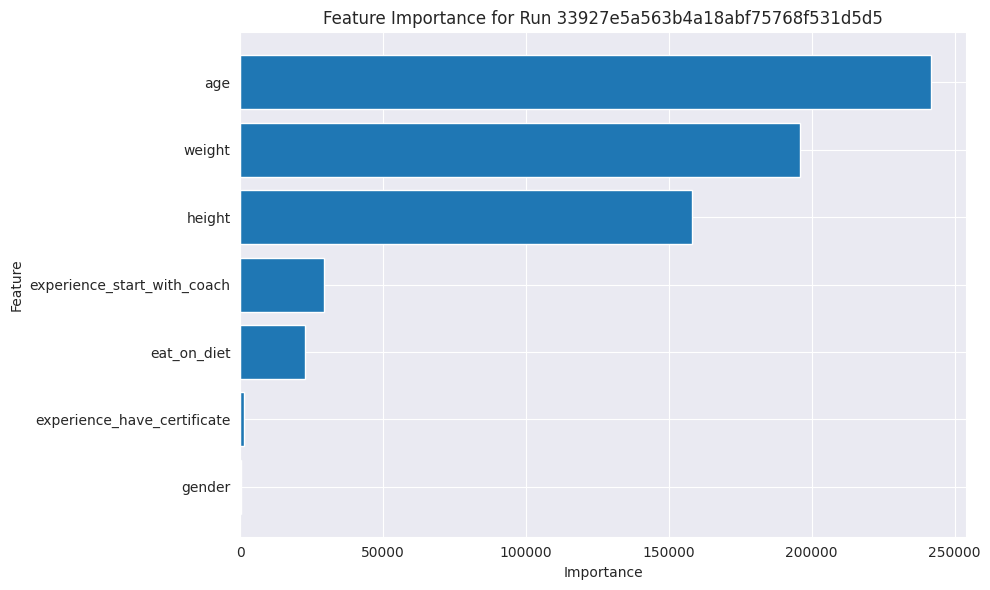

Processing Run ID: d461c6e959ee440a95c62a3f51c6956e
Model Path: downloaded_models/model_d461c6e959ee440a95c62a3f51c6956e.json
Loaded model from downloaded_models/model_d461c6e959ee440a95c62a3f51c6956e.json
Feature Importance Dictionary: {'gender': 1022.0, 'age': 21772.0, 'height': 15659.0, 'weight': 16651.0, 'experience_start_with_coach': 2827.0, 'experience_have_certificate': 1951.0, 'eat_on_diet': 1936.0}


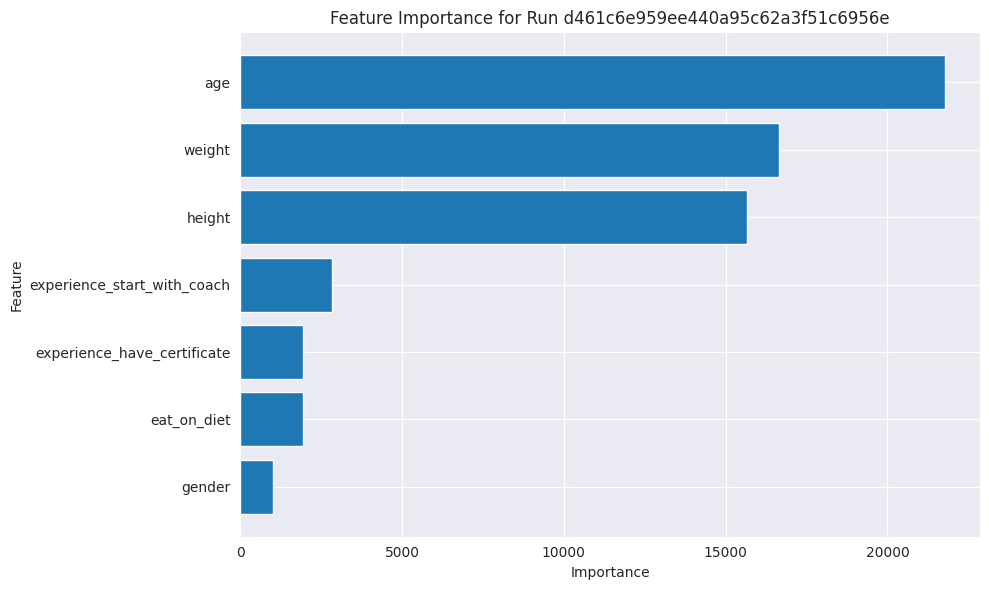

Processing Run ID: 51755a6354d546c9ad16f2b1831b0511
Model Path: downloaded_models/model_51755a6354d546c9ad16f2b1831b0511.json
Loaded model from downloaded_models/model_51755a6354d546c9ad16f2b1831b0511.json
Feature Importance Dictionary: {'gender': 150.0, 'age': 242723.0, 'height': 155678.0, 'weight': 209097.0}


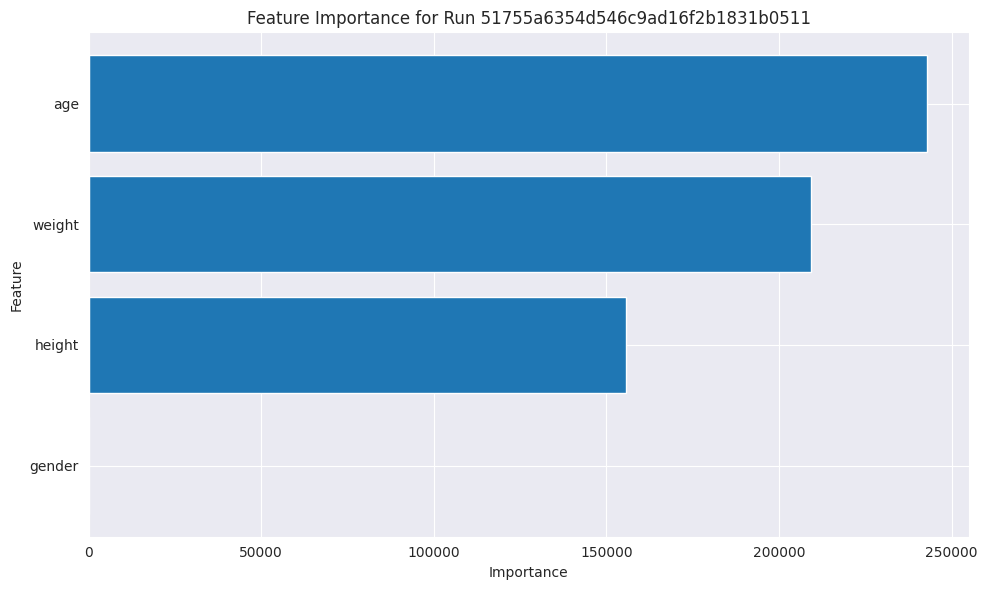

Processing Run ID: ff121a42f3114afdbdbf32294974aea6
Model Path: downloaded_models/model_ff121a42f3114afdbdbf32294974aea6.json
Loaded model from downloaded_models/model_ff121a42f3114afdbdbf32294974aea6.json
Feature Importance Dictionary: {'gender': 1121.0, 'age': 22419.0, 'height': 15750.0, 'weight': 18817.0}


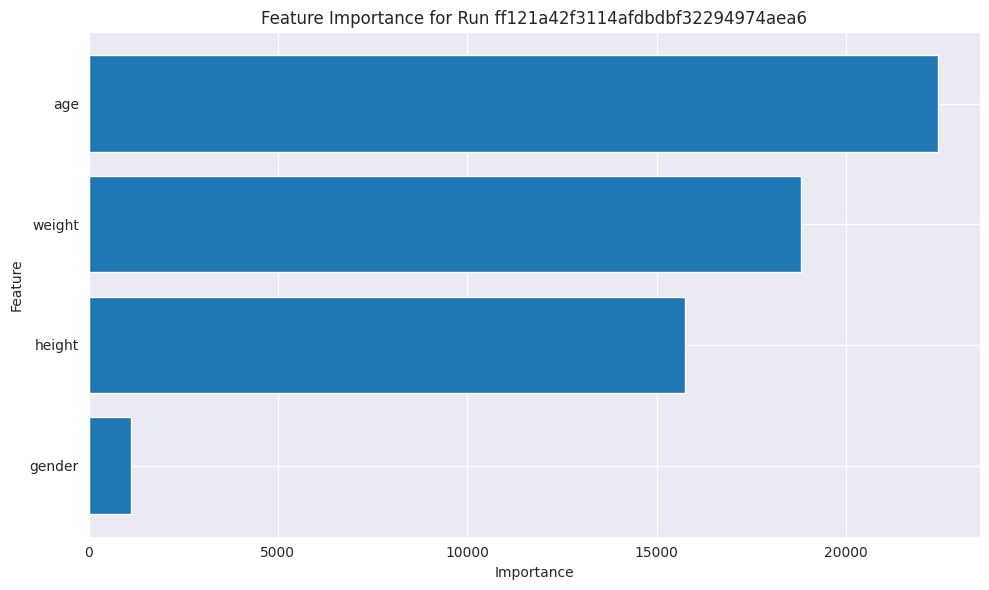

In [30]:
# Plot Feature Importance
for run in runs:
    run_id = run.info.run_id
    model_path = f'downloaded_models/model_{run_id}.json'
    print(f"Processing Run ID: {run_id}")
    print(f"Model Path: {model_path}")
    
    # Check if the model file exists
    if not os.path.isfile(model_path):
        print(f"Model file {model_path} does not exist.")
        continue
    
    # Load the model
    model = xgb.Booster()
    try:
        model.load_model(model_path)
        print(f"Loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        continue
    
    # Get feature importance
    importance = model.get_score(importance_type='weight')
    print(f"Feature Importance Dictionary: {importance}")
    
    importance_df = pd.DataFrame({
        'Feature': list(importance.keys()),
        'Importance': list(importance.values())
    }).sort_values(by='Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.gca().invert_yaxis()
    plt.title(f'Feature Importance for Run {run_id}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show() 

In [31]:
# Reconstruct Test Data
test_data = {}

for data_version, df in data_versions.items():
    X = df.drop('total_lift', axis=1)
    y = df['total_lift']
    # Ensure data types are consistent
    integer_columns = X.select_dtypes(include=['int']).columns
    X[integer_columns] = X[integer_columns].astype('float64')
    _, X_test, _, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    test_data[data_version] = (X_test, y_test)

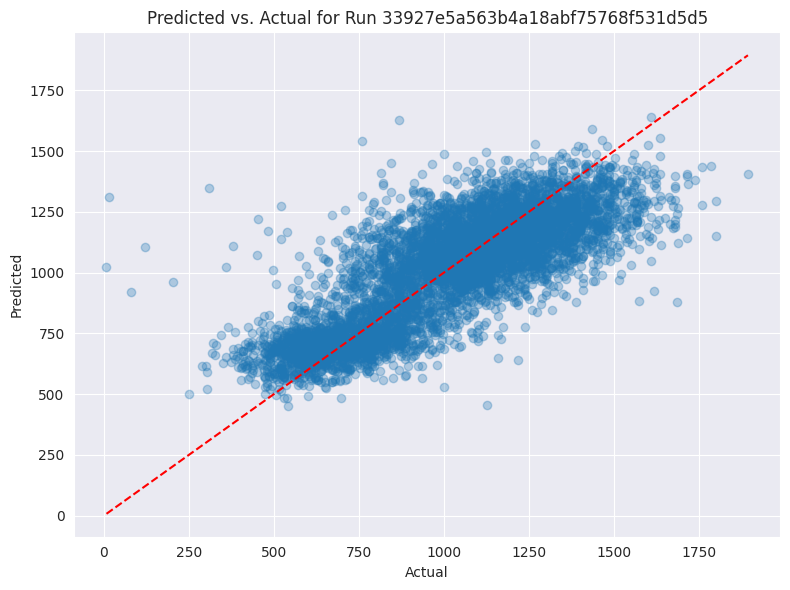

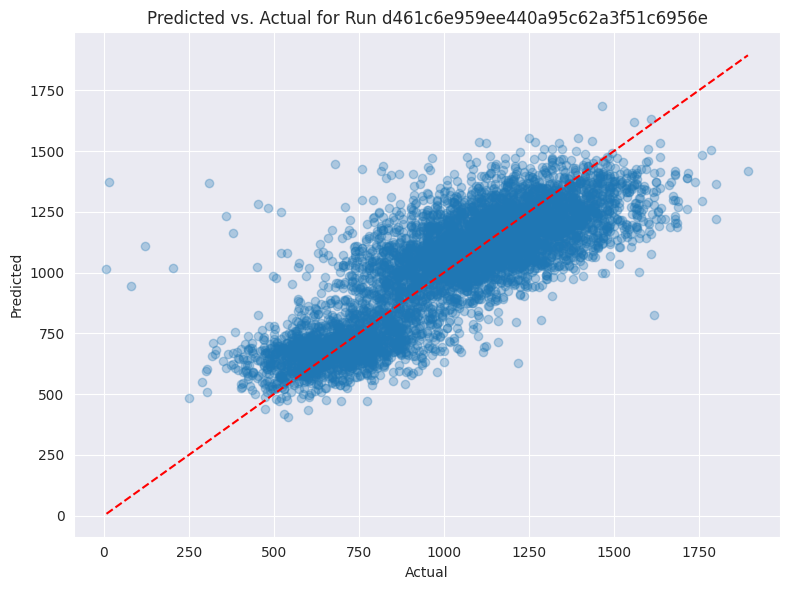

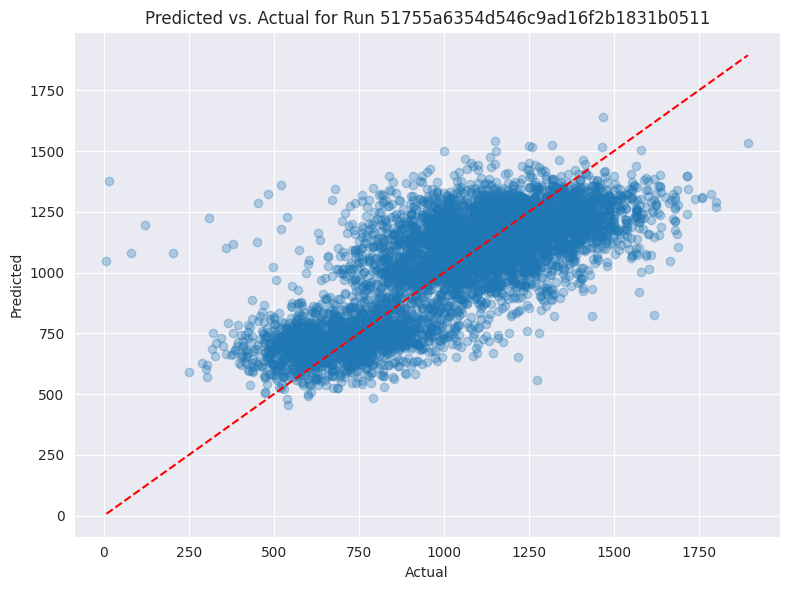

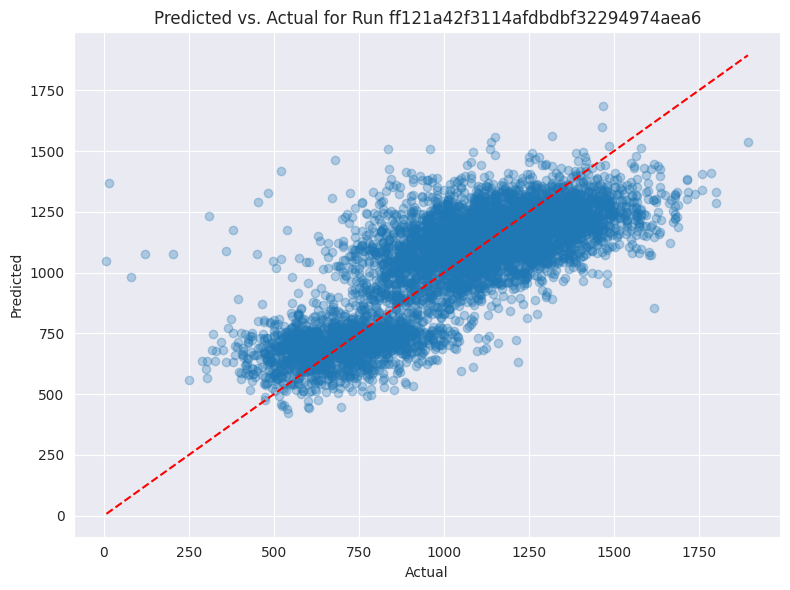

In [32]:
# Plot Predicted vs. Actual Values
for run in runs:
    run_id = run.info.run_id
    data_version = run.data.params.get('data_version')
    model_path = f'downloaded_models/model_{run_id}.json'
    # Load the model
    model = xgb.Booster()
    model.load_model(model_path)
    X_test, y_test = test_data[data_version]
    dtest = xgb.DMatrix(X_test)
    y_pred = model.predict(dtest)
    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Predicted vs. Actual for Run {run_id}')
    plt.tight_layout()
    plt.show()


#### 3.3.3 Compare Carbon Emissions

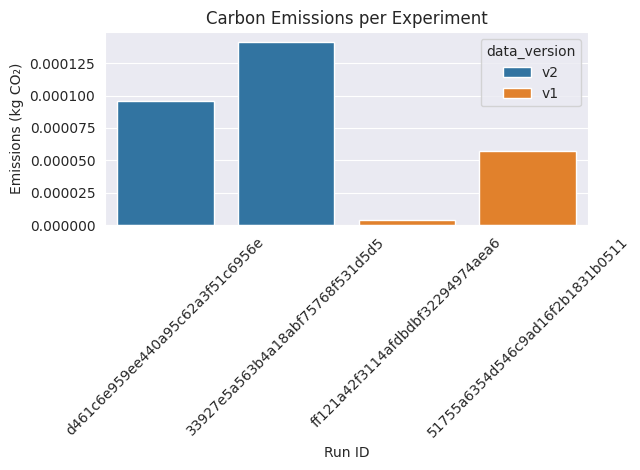

In [33]:
# Plot emissions
sns.barplot(data=results_df, x='run_id', y='emissions_kg', hue='data_version')
plt.xticks(rotation=45)
plt.title('Carbon Emissions per Experiment')
plt.xlabel('Run ID')
plt.ylabel('Emissions (kg CO₂)')
plt.tight_layout()
plt.show()

From the comparisons, we know the run id (d461c6e959ee440a95c62a3f51c6956e) which trained on datav2 with parameter_v1 has the least rmse in terms of test data. All of the features contribute importance to the model performance. And the carbon emissions of the run is efficient compared to others.